# State Estimation, Forward-Backward

In this demo we extend the previous, forward-only filtering demo with backward message passing (smoothing). Where the algorithm obtained in the previous demo is equivalent to Kalman filtering, the one is this demo is equivalent to Kalman smoothing. We will use the same state-space model as in the previous demo:

\begin{align*}
    n_t &\sim \mathcal{N}(0, 200)\\
    x_t &= x_{t-1} + 1.0\\
    y_t &= x_t + n_t
\end{align*}

The SSM can be represented as a Forney-style factor graph, where the pictured section is chained over time:

```
                 (u)
                  |
    (x_t_min) --> + --> = --> (x_t)
                        |    
               (n_t)--> +
                        |
                      (y_t)
```

In contrast to the previous demo, we will explicitly build the full generative model for the full data set (rolled out over time).

In [1]:
# Data
n_samples = 100
x_data = [t for t=1:n_samples] # State
y_data = x_data + sqrt(200.0)*randn(n_samples); # Noisy observations of state

# Model specification

In the model specification phase, we use `Variable` objects as Julia variables. This allows us to use flow operations, such as `for` and `if` during model construction.

The data are stored in a vector `y_data`. In order to simplify the data assimilation for batch estimation, the `placeholder()` function accepts an `index` argument. This index specifies which entry from the data vector corresponds to the argument variable. In the algorithm execution phase, this allows us to simply pass the data vector in its entirety to the `:y` field in the placeholder values dictionary.

In [2]:
using ForneyLab

g = FactorGraph()

# Prior statistics
m_x_0 = placeholder(:m_x_0)
v_x_0 = placeholder(:v_x_0)

# State prior
@RV x_0 ~ GaussianMeanVariance(m_x_0, v_x_0)

# Transition and observation model
x = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)

x_t_min = x_0
for t = 1:n_samples
    @RV n_t ~ GaussianMeanVariance(0.0, 200.0) # observation noise
    @RV x[t] = x_t_min + 1.0
    @RV y[t] = x[t] + n_t

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Algorithm generation

The inference algorithm can be generated in one just one line of code. The function `sumProductAlgorithm` generates a sum-product inference algorithm as a string, which is subsequently converted to a `step!` function for updating the maginals on the graph. 

In [3]:
eval(Meta.parse(sumProductAlgorithm(x))) # Load algorithm

step! (generic function with 3 methods)

# Execution

Compared to the previous demo, batch inference is much simpler because we do not explicitly have to pass the posterior statistics to the prior; the message passing schedule takes care of the forward and backward pass over time sections.

In [4]:
# Prepare data dictionary and prior statistics
data = Dict(:y     => y_data,
            :m_x_0 => 0.0,
            :v_x_0 => 1000.0)

# Execute algorithm
marginals = step!(data);

# Results

Compared to the previous demo (forward-only), the state estimation algorithm in this demo also passes messages backward in time. Therefore, the state estimates are more accurate than the filtering result of the previous demo.

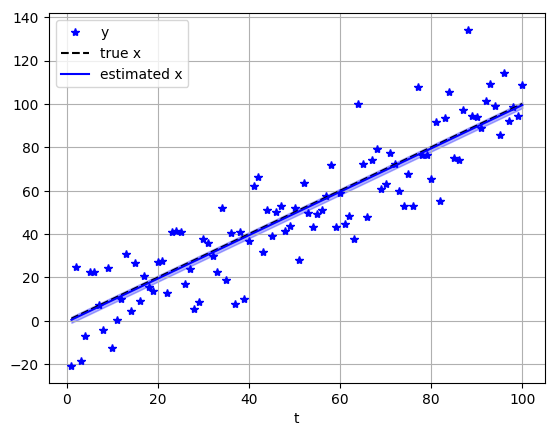

In [5]:
using PyPlot

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples]

plot(collect(1:n_samples), y_data, "b*", label="y")
plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(1:n_samples, m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
legend(loc="upper left");